# This project is Threat Prediction based on the ML-Based WAF but made using pyspark
Link to github
[here](https://github.com/vladan-stojnic/ML-based-WAF)

# Setting Up Java and Spark


In [2]:
#Install Java
#Installing Spark
#UnTar files
#Installing Modules
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q  https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=9fd042eda6b713aefecec9ba109f534be92779a478e188bb447e137d65d34ed2
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


# Import Section and Initialization

In [5]:
from google.colab import drive
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, concat,lit,when
from pyspark.sql import SparkSession
import findspark
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,RandomForestClassifier
from pyspark.ml.evaluation import ClusteringEvaluator,MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sn
import os
findspark.init()
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [6]:
spark = SparkSession.builder.appName("ML-BASED-WAF").getOrCreate()

# Data and Processing

In [7]:
drive.mount('/content/drive')
XSS_df = spark.read.csv('/content/drive/MyDrive/Dataset_WAF/XSS_dataset.csv',header=True,escape="\"")
Http_Params_df = spark.read.csv('/content/drive/MyDrive/Dataset_WAF/payload_full.csv',header=True,escape="\"")
Http_Params_lex_df = spark.read.csv('/content/drive/MyDrive/Dataset_WAF/payload_test_lexical.csv',header=True,escape="\"")
Emcl_data = spark.read.json('/content/drive/MyDrive/Dataset_WAF/ecml_data.json')

Mounted at /content/drive


In [8]:
XSS_df_with_type = ( XSS_df.withColumn("Sentence",concat(col("Sentence"),lit("xss")))
.withColumn("Label", when(col("Label")==1,"xss").otherwise("valid")).drop("_c0")
                     )

In [9]:
Http_Params_df_processed = (
    Http_Params_df.withColumn("attack_type",when(col("attack_type") == "norm", "valid").otherwise(col("attack_type"))).drop("length").drop("label"))


In [10]:
Http_Params_lex_df_processed = (Http_Params_lex_df.withColumn("attack_type", when(col("attack_type") == "sql-syntax", "sqli")
                                  .when(col("attack_type") == "js-syntax", "xss")
                                   .when(col("attack_type") == "norm", "valid")
                                  .otherwise(col("attack_type"))).drop("length").drop("label")
)


In [11]:
complete_df = (
   XSS_df_with_type.select("Sentence","Label")
   .union(Emcl_data.select("pattern","type").withColumnRenamed("pattern","Sentence").withColumnRenamed("type","Label"))
   .union(Http_Params_df_processed.select("payload","attack_type").withColumnRenamed("pattern","Sentence").withColumnRenamed("type","Label"))
   .union(Http_Params_lex_df_processed.select("payload","attack_type").withColumnRenamed("pattern","Sentence").withColumnRenamed("type","Label"))
)

+--------------+-----+
|         Label|count|
+--------------+-----+
|         valid|61623|
|          sqli|13240|
|           xss| 9749|
|          cmdi| 3461|
|path-traversal| 3286|
+--------------+-----+



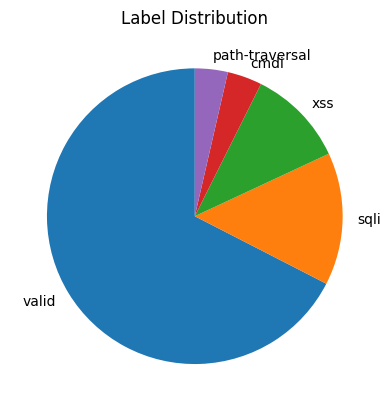

In [12]:
import matplotlib.pyplot as plt
counts = complete_df.groupBy("Label").count().orderBy("count",ascending=False)
counts.show()
label_counts = counts.collect()
labels = [row["Label"] for row in label_counts]
counts = [row["count"] for row in label_counts]

# Plot the bar chart
plt.pie(counts, labels=labels, startangle=90)
plt.title("Label Distribution")
plt.show()

In [13]:
complete_df_numeric_labels = complete_df.withColumn("Label", when(col("Label") == "valid", 0)
                                  .when(col("Label") == "sqli", 1)
                                   .when(col("Label") == "xss", 2)
                                   .when(col("Label") == "cmdi", 3)
                                   .when(col("Label") == "path-traversal", 4)
                                  .otherwise(col("Label").cast("int"))
                  )

# Applying ML Models and Accuracy Metrics

# Tokenized and Vectorized Data

In [14]:
#Pipeline
tokenizer = Tokenizer(inputCol="Sentence",outputCol="words")
vectorizer = CountVectorizer(inputCol="words",outputCol="features")
pipes = Pipeline(stages=[tokenizer,vectorizer])

In [15]:
#transformed Data
transformed_Data=pipes.fit(complete_df_numeric_labels).transform(complete_df_numeric_labels)
(train_data,test_data)=transformed_Data.randomSplit([0.8,0.2],seed=123)
transformed_Data.show()

+--------------------+-----+--------------------+--------------------+
|            Sentence|Label|               words|            features|
+--------------------+-----+--------------------+--------------------+
|<li><a href="/wik...|    0|[<li><a, href="/w...|(141448,[6,20,28,...|
|<tt onmouseover="...|    2|[<tt, onmouseover...|(141448,[832,1107...|
|\t </span> <span ...|    0|[, , </span>, <sp...|(141448,[0,11,13,...|
|\t </span> <span ...|    0|[, , </span>, <sp...|(141448,[0,13,26,...|
|\t </span>. <a hr...|    0|[, , </span>., <a...|(141448,[0,6,13,2...|
|<li id="cite_note...|    0|[<li, id="cite_no...|(141448,[6,13,47,...|
|<li><a href="/wik...|    0|[<li><a, href="/w...|(141448,[6,19,28,...|
|<li id="cite_note...|    0|[<li, id="cite_no...|(141448,[6,13,20,...|
| <tr><td class="p...|    0|[, <tr><td, class...|(141448,[0,3338,3...|
|       \t </span>xss|    0|    [, , </span>xss]|(141448,[0,92],[2...|
|<li><a href="/wik...|    0|[<li><a, href="/w...|(141448,[28,370,6...|
|<a on

# Logistic Regression

In [16]:
lr = LogisticRegression(featuresCol="features", labelCol="Label", maxIter=10)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_predictions)
print(f"LR Accuracy: {lr_accuracy}")

LR Accuracy: 0.9255012739559101


# Random Forest

In [18]:
rf = RandomForestClassifier(featuresCol="features", labelCol="Label", numTrees=10)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy}")

Random Forest Accuracy: 0.6803478453528304


# K-Means

In [21]:
k=5
transformed_Data=pipes.fit(complete_df).transform(complete_df)
kmeans = KMeans(k=k, featuresCol="features", predictionCol="prediction")
model = kmeans.fit(transformed_Data)
clustered_data = model.transform(transformed_Data)
evaluator = ClusteringEvaluator()
score = evaluator.evaluate(clustered_data)
print(f"Clustering Score: {score}")

Clustering Score: 0.4263114730191559
